In [2]:
import time
from pathlib import Path

import numpy as np
from keras.utils import image_dataset_from_directory
from keras.models import Sequential, load_model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.applications import MobileNetV3Small
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import cv2

In [59]:
TRAINING_DS_DIR = 'data/output/'
TEST_DATASET_DIR = "data/test_dataset/"
MODEL_PATH = 'data/model/'
OV_MODEL_PATH = 'data/model_ov'
IMG_SIZE = (90, 90)
INPUT_SHAPE = tuple(list(IMG_SIZE) + [3])
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
EPOCHS = 10

MODE = 'LOAD'  # LOAD / BUILD
TRAIN = False

## Load dataset

Found 2725 files belonging to 2 classes.
Using 2180 files for training.
Found 2725 files belonging to 2 classes.
Using 545 files for validation.


C:\Users\Krystian\mgr\pb\splinter\venv\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


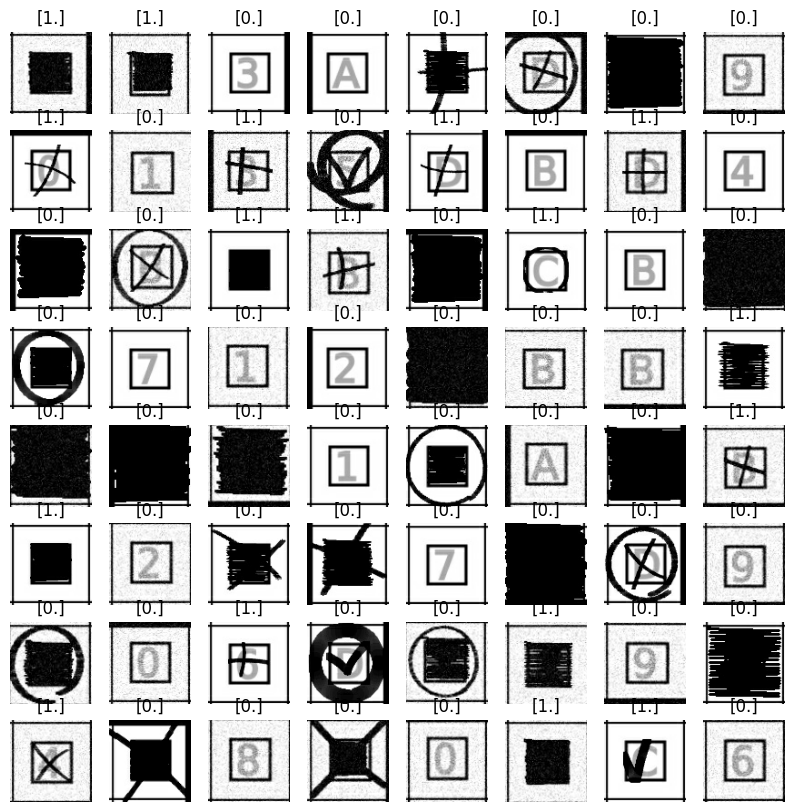

In [28]:
def image_dataset(subset: str) -> 'tf.data.Dataset':
    return image_dataset_from_directory(
        TRAINING_DS_DIR,
        validation_split=0.2,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        label_mode='binary'
    )


train_ds = image_dataset("training")
val_ds = image_dataset("validation")

grid_size = 8
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(grid_size * grid_size):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(label[i].numpy())
        plt.axis("off")
    plt.show()

## Create model

In [5]:
if MODE == "BUILD":
    base_model = MobileNetV3Small(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights="imagenet"
    )
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
else:
    model = load_model(MODEL_PATH)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 3, 3, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 577       
                                                                 
Total params: 939,697
Trainable params: 927,585
Non-trainable params: 12,112
_________________________________________________________________


## Train

In [ ]:
if TRAIN:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS
    )

    Path(MODEL_PATH).mkdir(parents=True, exist_ok=True)
    model.save(MODEL_PATH)

## Visualize training result

In [ ]:
if 'history' in globals():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
! pip install openvino-dev[tensorflow] --quiet
! mo --saved_model_dir $MODEL_PATH --output_dir $OV_MODEL_PATH

## Test model

4
1/1 [==============================] - 0s 16ms/step


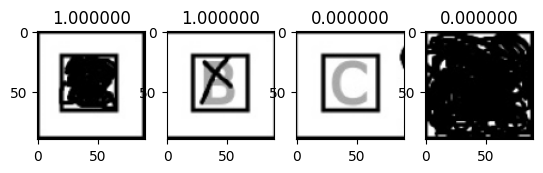

In [12]:
full_img = cv2.imread("data/test/mark_boxes.jpg", cv2.IMREAD_COLOR)
x_slices = np.linspace(0, full_img.shape[1], 5)
images = [full_img[:, int(x1):int(x2)] for x1, x2 in zip(x_slices[:-1], x_slices[1:])]
print(len(images))
images = [cv2.resize(img, dsize=IMG_SIZE) for img in images]

images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
f, ax = plt.subplots(1, 4)
for i, img in enumerate(images):
    ax[i].imshow(img)
    prediction = model.predict(np.array([img]))[0][0]
    ax[i].title.set_text(f"{prediction:4f}")
plt.show()

In [66]:
test_dataset = image_dataset_from_directory(
    TEST_DATASET_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary'
)

Found 100000 files belonging to 2 classes.


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
def evaluate_model(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        predictions = model.predict(images, verbose=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.round().flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return accuracy, precision, recall

# Evaluate the model on the test dataset
t0 = time.perf_counter_ns()
accuracy, precision, recall = evaluate_model(model, test_dataset)
t1 = time.perf_counter_ns()
print(f"Time: {(t1 - t0) / 1e6} ms")
print(f"Dataset size: {len(test_dataset) * BATCH_SIZE}")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


1/1 [==============================] - 0s 30ms/step
Time: 123049.8168 ms
Dataset size: 100032
Accuracy: 0.99985, Precision: 1.0, Recall: 0.9995498739647101
